In [67]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import r_regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.datasets import load_iris
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

In [74]:
data = pd.read_csv('/content/drive/MyDrive/Final_Project/shopping_behavior_updated.csv')
data.head()

#Looking at the data and the columns

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


The data has a lot of columns for us to look at. I will begin by playing with different graphs, and looking for any relationships that are important.

Our two goals are to look at what factors increase the **amount of money** spent in a purchase, and what factors tend to lead to more **customers returning more frequently**.

The factors I initally look at are factors that I suspect will be influential, based on my previous research and experience. This will help me get an idea of how some of the data is spread out, but we will have a better idea when we try the **greedy forward algorithm** to determine which factors are the most influential!

Text(0.5, 1.0, 'Gender vs. Amount of Purchases')

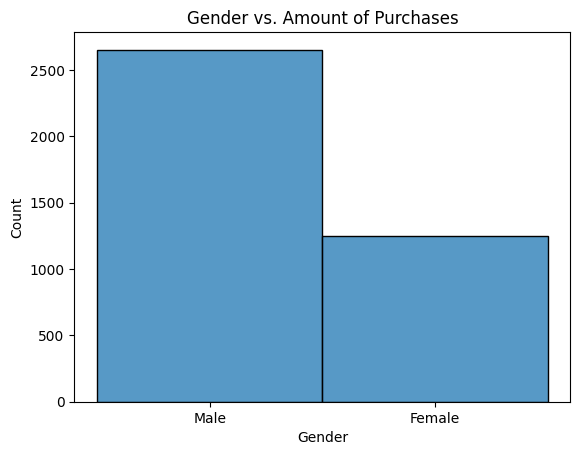

In [ ]:
sns.histplot(data['Gender'])
plt.title('Gender vs. Amount of Purchases')

Text(0.5, 1.0, 'Gender vs. Purchase Amount')

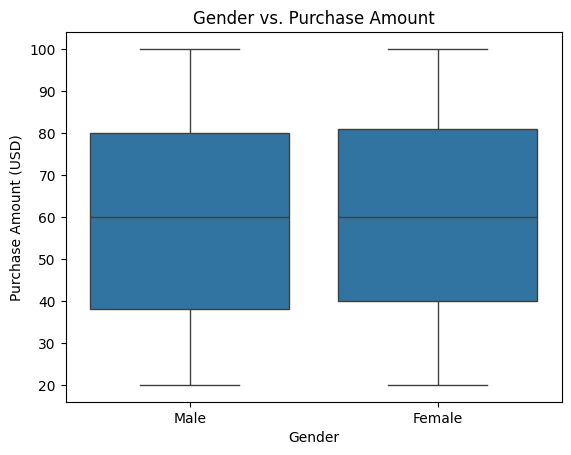

In [ ]:
#lets look at a few columns
#starting with gender and purchase amts.



sns.boxplot(x='Gender', y='Purchase Amount (USD)', data=data)
plt.title('Gender vs. Purchase Amount')

In [ ]:
males = data[data['Gender'] == 'Male']
females = data[data['Gender'] == 'Female']

males['Purchase Amount (USD)'].describe()

,Purchase Amount (USD)
count,2652.000000
mean,59.536199
std,23.809976
min,20.000000
25%,38.000000
50%,60.000000
75%,80.000000
max,100.000000


In [ ]:
females['Purchase Amount (USD)'].describe()

,Purchase Amount (USD)
count,1248.000000
mean,60.249199
std,23.420556
min,20.000000
25%,40.000000
50%,60.000000
75%,81.000000
max,100.000000


As seen above, gender does not make seem to be a major indicator on the purchase size. We will rougly look at a few other columns before trying other methods to figure out how we can identify which are the most indicative columns.

I started using a sample of the data, as 3900 points becomes too much to display on a scatter plot. I played around with different amounts, but using 50% of the data seems to show trends.

Text(0.5, 1.0, 'Discount Applied vs. Purchase Amount')

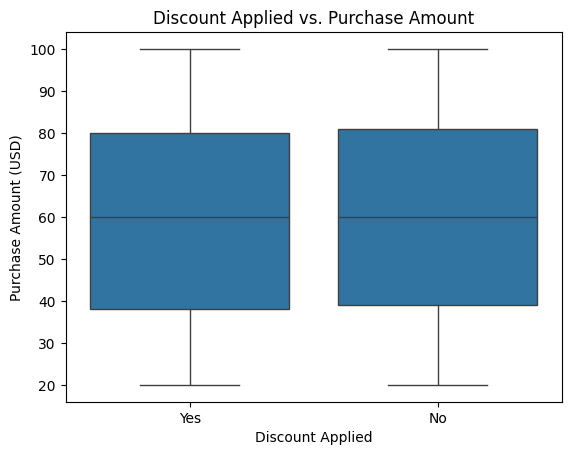

In [ ]:
sns.boxplot(x = data['Discount Applied'], y = data['Purchase Amount (USD)'])
plt.title('Discount Applied vs. Purchase Amount')

Text(0.5, 1.0, 'Age vs Purchase Amount')

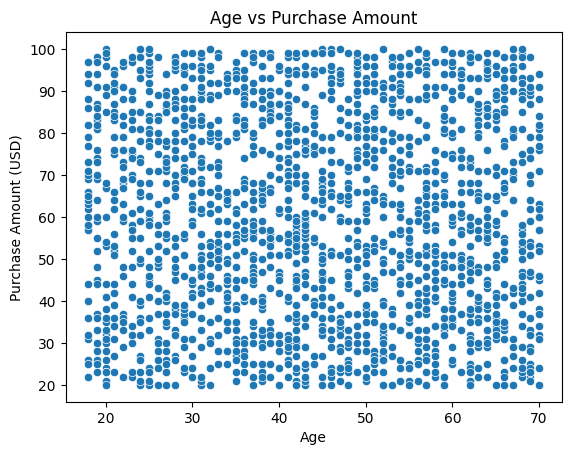

In [ ]:
data_sample = data.sample(frac = .5, random_state = 1)
sns.scatterplot(x = data_sample['Age'], y = data_sample['Purchase Amount (USD)'])
plt.title('Age vs Purchase Amount')

Text(0.5, 1.0, 'Category vs Purchase Amount')

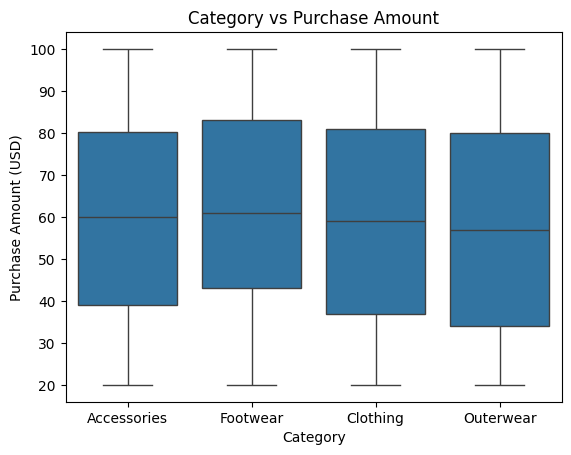

In [ ]:
sns.boxplot(x = data_sample['Category'], y = data_sample['Purchase Amount (USD)'])
plt.title('Category vs Purchase Amount')

Of the previous 3 factors, the category of the product seems to have more of an influence on the purchase size.

Text(0.5, 1.0, 'Frequency of Purchases')

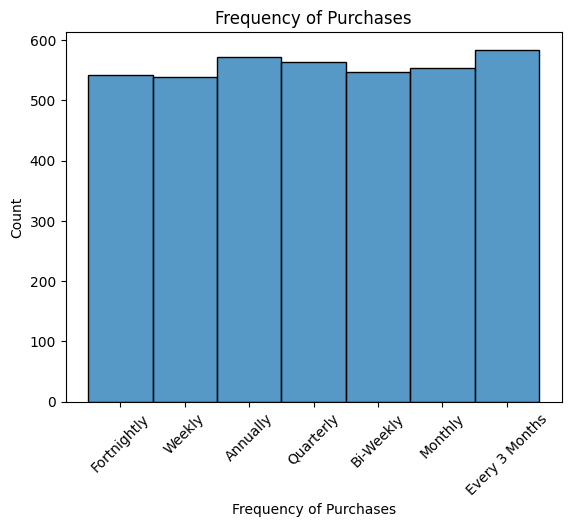

In [ ]:
sns.histplot(data['Frequency of Purchases'])
plt.xticks(rotation=45)
plt.title('Frequency of Purchases')


Text(0.5, 1.0, 'Frequency of Purchases vs Purchase Amount')

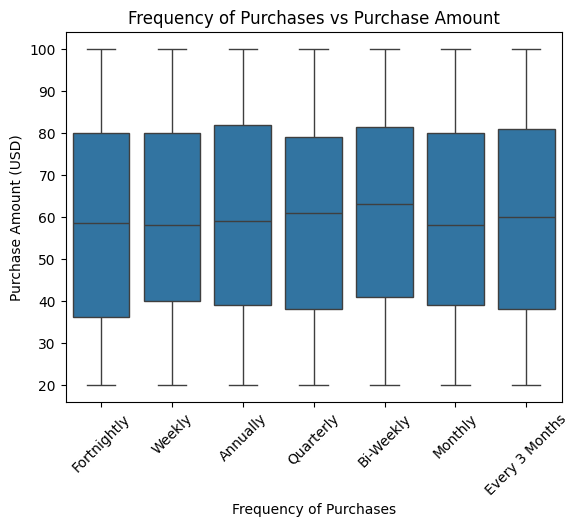

In [ ]:
sns.boxplot(x = data['Frequency of Purchases'], y = data['Purchase Amount (USD)'])
plt.xticks(rotation=45)
plt.title('Frequency of Purchases vs Purchase Amount')

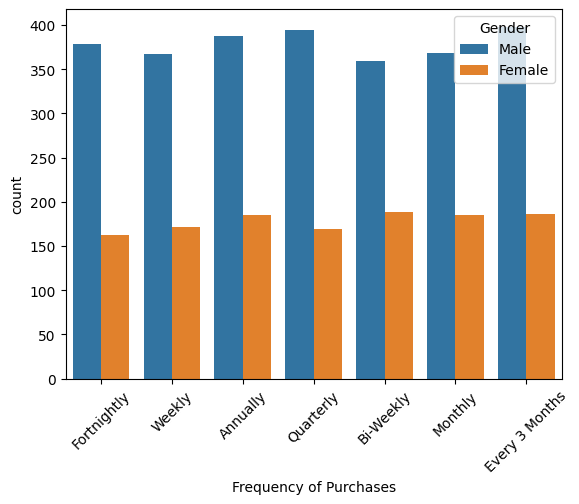

In [ ]:
sns.countplot(data=data, x = "Frequency of Purchases", hue="Gender")
plt.xticks(rotation = 45)
plt.show()

I want to get a deeper look into the difference between the genders and the frequency of purchases, so I will conduct a **t-test**.

For the **null hypothesis**: There is no significant difference between the two genders and their shopping frequency.

**Alternative Hypothesis**: There is a difference between the genders.

Before I begin, I need to **hot-encode** the Frequency variable, which will help me in developing future models as well!

The scale will be 1: Least Frequent (Annually) - 7: Most Frequent (Fortnightly)

In [ ]:
#hot encoding the frequency variable.

data['Frequency Encoded'] = data['Frequency of Purchases'].map({
    'Annually': 1,
    'Quarterly': 2,
    'Every 3 Months': 3,
    'Monthly': 4,
    'Weekly': 5,
    'Biweekly': 6,
    'Fortnightly': 7
})

#displaying just to make sure it encoded properly
data[['Customer ID', 'Frequency of Purchases', 'Frequency Encoded']][0:10]

,Customer ID,Frequency of Purchases,Frequency Encoded
0,1,Fortnightly,7.0
1,2,Fortnightly,7.0
2,3,Weekly,5.0
3,4,Weekly,5.0
4,5,Annually,1.0
5,6,Weekly,5.0
6,7,Quarterly,2.0
7,8,Weekly,5.0
8,9,Annually,1.0
9,10,Quarterly,2.0


In [ ]:
data['Frequency Encoded'].isnull().sum()
#we will inject the median into the null values, since we now are able to use the column numerically

np.int64(547)

In [ ]:
data['Frequency Encoded'] = data['Frequency Encoded'].fillna(data['Frequency Encoded'].median())
data['Frequency Encoded'].isnull().sum()


np.int64(0)

In [ ]:
#now setting up the t-test:
females = data[data['Gender'] == 'Female']['Frequency Encoded']
males = data[data['Gender'] == 'Male']['Frequency Encoded']


ttest_ind(a=males,
          b=females,
          equal_var=False, alternative='two-sided')



TtestResult(statistic=np.float64(0.518038647587995), pvalue=np.float64(0.6044772294810729), df=np.float64(2495.3900834759243))

My statistic number was about .53, meaning that females tend to buy *less* frequently than males.

The p-value was about .60, which is much higher than .05. This number being larger tells us that **there is no statistical significant difference** between the mean frequency of purchases between the two genders. We can **accept the null hypothesis**, and reject the alternative.

On the surface, it seemed like males purchased with more frequency, but using the t-test allowed us to see that there is in fact no statistical significant difference between the frequency of purchases between the genders.



---



We could keep searching for key features manually using tests like these, but a greedy algorithm could save us some time. It is very interesting to apply our in class technique to a data set, and see how we can explore different relationships beyond the surface level.



In [ ]:
# I will first encode the other features I want to use that aren't previously numeric
data['Discount Encoded'] = data['Discount Applied'].map({
    'Yes': 1,
    'No': 0
})

data['Season Encoded'] = data['Season'].map({
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
})


data[['Discount Applied', 'Discount Encoded', 'Season', 'Season Encoded']][1675:1685]



,Discount Applied,Discount Encoded,Season,Season Encoded
1675,Yes,1,Spring,1
1676,Yes,1,Winter,0
1677,No,0,Summer,2
1678,No,0,Summer,2
1679,No,0,Fall,3
1680,No,0,Summer,2
1681,No,0,Winter,0
1682,No,0,Fall,3
1683,No,0,Spring,1
1684,No,0,Spring,1


In [ ]:
from re import X
#setting up the greedy algorithm model to see what affects frequency of purchases

# Load sample data

featured_cols = data[['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Review Rating', 'Discount Encoded', 'Season Encoded', ]]

X = featured_cols.values
y = data[['Frequency Encoded']].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define model
model = LinearRegression()

# Forward selection
sfs = SequentialFeatureSelector(model, n_features_to_select=3, direction='forward')
sfs.fit(X_train, y_train)

# Selected features
print("Selected features:", sfs.get_support())
print(featured_cols.columns[sfs.get_support()])

Selected features: [False  True  True  True False False]
Index(['Purchase Amount (USD)', 'Previous Purchases', 'Review Rating'], dtype='object')


Based on the Sequential Feature Selector algorithm, from the set of columns I selected, we can see that the most influential factors for Frequency of Purchases are **Purchase Amount**, **Previous Purcases**, and **Review Rating**.

I selected the 6 columns based on eliminating some that I already looked at, and choosing ones that already had numerical values or were simple to encode.

With this information, I can now create a prediction model to predict how frequently a customer may make purchase, and I could redo this to find the most influential variables for the Purchase Amount.

In [ ]:
#connecting to git repo



SyntaxError: invalid syntax (ipython-input-1249491621.py, line 3)